# Weak and Strong Scaling — Setup

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import math

BASE_RESULTS_DIR = Path("results")
BASE_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

CPU_CORES_PER_NODE = 128
GPUS_PER_NODE = 4
BASE_EFF_NPROCS = 2  # baseline fixo para eficiência paralela (CPU e GPU)

def prepare_data(csv_file, prefix, baseline_nprocs=None):
    results_dir = BASE_RESULTS_DIR / prefix
    results_dir.mkdir(parents=True, exist_ok=True)

    df = pd.read_csv(csv_file, parse_dates=["datetime"])
    # CSV agora já tem total_time
    # colunas esperadas:
    # datetime,power,total_particles,length_per_rank,num_procs,box_length,RAM_GB,gen_time,splitters_time,dist_time,total_time,device,seed,mode

    counts = df.groupby(["device","power","num_procs"]).size()
    print(f"[{prefix}] Runs per configuration:")
    print(counts)

    summary = (
        df.groupby(["device","power","num_procs"], as_index=False)
          .agg(
              gen_mean=("gen_time","mean"),           gen_std=("gen_time","std"),
              split_mean=("splitters_time","mean"),   split_std=("splitters_time","std"),
              dist_mean=("dist_time","mean"),         dist_std=("dist_time","std"),
              total_mean=("total_time","mean"),       total_std=("total_time","std"),
              runs=("total_time","count")
          )
    )

    def calc_nodes(row):
        dev = str(row["device"]).lower()
        if dev == "cpu":
            return int(math.ceil(row["num_procs"] / float(CPU_CORES_PER_NODE)))
        else:
            return int(math.ceil(row["num_procs"] / float(GPUS_PER_NODE)))
    summary["nodes"] = summary.apply(calc_nodes, axis=1)

    cpu_only = summary[summary["device"] == "cpu"].copy()
    if baseline_nprocs is None:
        cpu_base = (cpu_only.sort_values(["power","num_procs"])
                            .groupby("power", as_index=False)
                            .first())
    else:
        cpu_base = cpu_only[cpu_only["num_procs"] == baseline_nprocs].copy()
        if cpu_base.empty:
            raise ValueError(f"No CPU baseline with num_procs={baseline_nprocs}.")

    cpu_base = cpu_base.rename(columns={
        "num_procs":"cpu_base_nprocs",
        "gen_mean":"gen_cpu","gen_std":"gen_cpu_std",
        "split_mean":"split_cpu","split_std":"split_cpu_std",
        "dist_mean":"dist_cpu","dist_std":"dist_cpu_std",
        "total_mean":"total_cpu","total_std":"total_cpu_std",
    })[["power","cpu_base_nprocs","gen_cpu","gen_cpu_std","split_cpu","split_cpu_std","dist_cpu","dist_cpu_std","total_cpu","total_cpu_std"]]

    with_base = summary.merge(cpu_base, on="power", how="inner")

    def ratio(a,b): 
        a = np.asarray(a, float); b = np.asarray(b, float)
        out = np.full_like(a, np.nan, dtype=float)
        ok = (b > 0) & np.isfinite(b)
        out[ok] = a[ok] / b[ok]
        return out

    def ratio_std(a,sa,b,sb):
        a = np.asarray(a, float); sa = np.asarray(sa, float)
        b = np.asarray(b, float); sb = np.asarray(sb, float)
        s = ratio(a,b)
        out = np.full_like(s, np.nan, dtype=float)
        ok = (a>0)&(b>0)&np.isfinite(a)&np.isfinite(b)
        out[ok] = s[ok] * np.sqrt( (sa[ok]/a[ok])**2 + (sb[ok]/b[ok])**2 )
        return out

    with_base["speedup_gen"]     = ratio(with_base["gen_cpu"],   with_base["gen_mean"])
    with_base["speedup_gen_s"]   = ratio_std(with_base["gen_cpu"], with_base["gen_cpu_std"], with_base["gen_mean"], with_base["gen_std"])

    with_base["speedup_split"]   = ratio(with_base["split_cpu"], with_base["split_mean"])
    with_base["speedup_split_s"] = ratio_std(with_base["split_cpu"], with_base["split_cpu_std"], with_base["split_mean"], with_base["split_std"])

    with_base["speedup_dist"]    = ratio(with_base["dist_cpu"],  with_base["dist_mean"])
    with_base["speedup_dist_s"]  = ratio_std(with_base["dist_cpu"], with_base["dist_cpu_std"], with_base["dist_mean"], with_base["dist_std"])

    with_base["speedup_total"]   = ratio(with_base["total_cpu"], with_base["total_mean"])
    with_base["speedup_total_s"] = ratio_std(with_base["total_cpu"], with_base["total_cpu_std"], with_base["total_mean"], with_base["total_std"])

    return df, summary, with_base, results_dir

def savefig(results_dir, name):
    plt.tight_layout()
    plt.savefig(results_dir / f"{name}.png", dpi=150)
    plt.show()
    plt.close()

## Load data (choose weak or strong)

In [ ]:
# Choose one:
df, summary, with_base, results_dir = prepare_data("results_strong.csv", "strong")
# df, summary, with_base, results_dir = prepare_data("results_weak.csv", "weak")

[weak] Runs per configuration:
device  power  num_procs
cpu     8      1             5
               2             5
               4             5
               6             5
               8             5
               16            5
               24            5
               32            5
               50            5
               64            5
               128           5
               256           5
               512           5
gpu     8      1            10
               2            10
               4            10
               6            10
               8            10
               16           10
               24           10
               32           10
               50           10
               64           10
               128          10
               256          10
               512          10
dtype: int64


## Bar chart — Total time per run (categorical X)

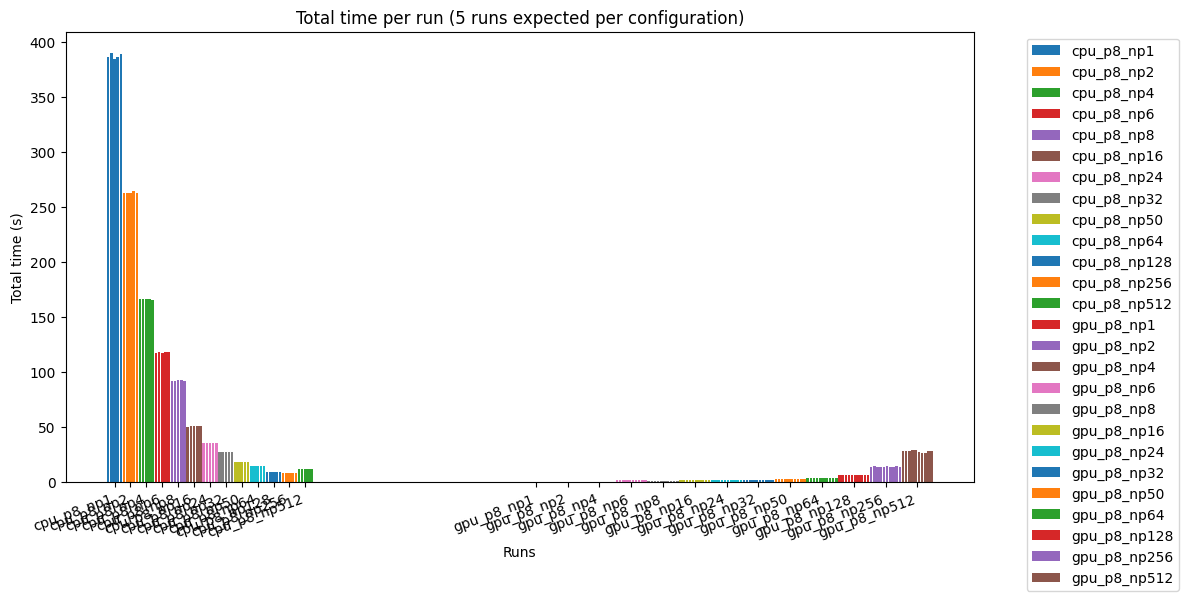

In [28]:
plt.figure(figsize=(12, 6))
for i, (key, group) in enumerate(df.groupby(["device","power","num_procs"])):
    label = f"{key[0]}_p{key[1]}_np{key[2]}"
    xpos = range(i*len(group), (i+1)*len(group))
    plt.bar(xpos, group["total_time"], label=label)
tick_positions, tick_labels = [], []
for i, (key, group) in enumerate(df.groupby(["device","power","num_procs"])):
    center = i*len(group) + len(group)/2 - 0.5
    tick_positions.append(center)
    tick_labels.append(f"{key[0]}_p{key[1]}_np{key[2]}")
plt.xticks(tick_positions, tick_labels, rotation=20, ha="right")
plt.ylabel("Total time (s)")
plt.xlabel("Runs")
plt.title("Total time per run (5 runs expected per configuration)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
savefig(results_dir, "bars_total_time")

## Mean time vs processors — Distribution

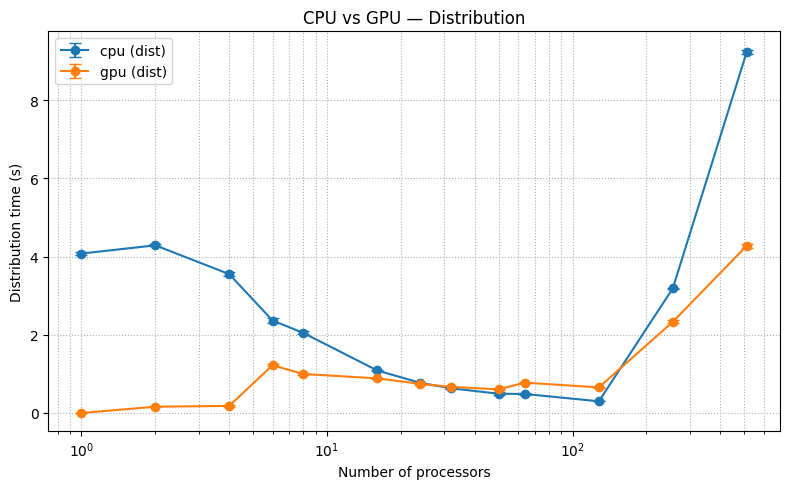

In [29]:
plt.figure(figsize=(8,5))
for dev in summary["device"].unique():
    sub = summary[summary["device"] == dev].sort_values("num_procs")
    plt.errorbar(sub["num_procs"], sub["dist_mean"], yerr=sub["dist_std"], marker="o", capsize=4, label=f"{dev} (dist)")
plt.xscale("log")
plt.xlabel("Number of processors")
plt.ylabel("Distribution time (s)")
plt.title("CPU vs GPU — Distribution")
plt.legend(); plt.grid(True, which="both", ls=":")
savefig(results_dir, "distribution_time")

## Mean time vs processors — Splitters (partitioning/selection)

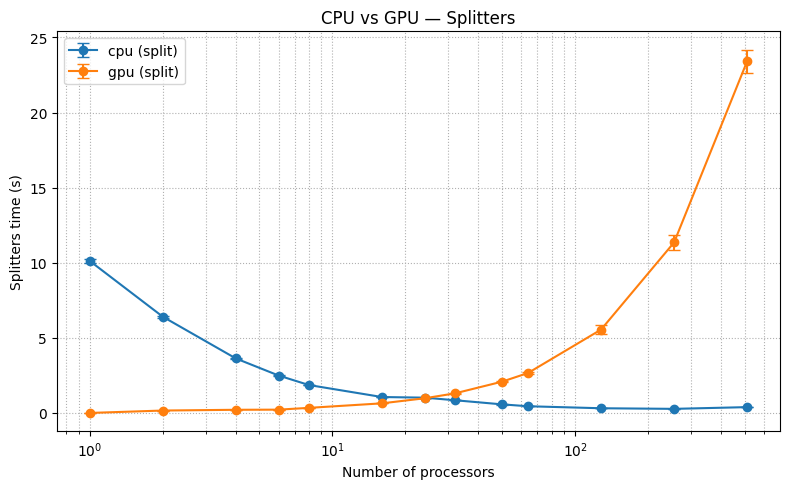

In [39]:
plt.figure(figsize=(8,5))
for dev in summary["device"].unique():
    sub = summary[summary["device"] == dev].sort_values("num_procs")
    plt.errorbar(sub["num_procs"], sub["split_mean"], yerr=sub["split_std"], marker="o", capsize=4, label=f"{dev} (split)")
plt.xscale("log")
plt.xlabel("Number of processors")
plt.ylabel("Splitters time (s)")
#plt.yscale("log")
plt.title("CPU vs GPU — Splitters")
plt.legend(); plt.grid(True, which="both", ls=":")
savefig(results_dir, "splitters_time")

## Mean time vs processors — Generation

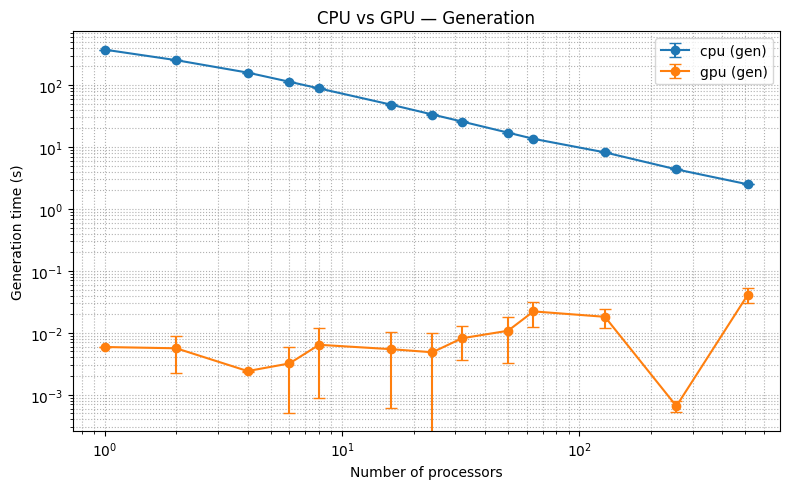

In [40]:
plt.figure(figsize=(8,5))
for dev in summary["device"].unique():
    sub = summary[summary["device"] == dev].sort_values("num_procs")
    plt.errorbar(sub["num_procs"], sub["gen_mean"], yerr=sub["gen_std"], marker="o", capsize=4, label=f"{dev} (gen)")
plt.xscale("log")
plt.xlabel("Number of processors")
plt.yscale("log")
plt.ylabel("Generation time (s)")
plt.title("CPU vs GPU — Generation")
plt.legend(); plt.grid(True, which="both", ls=":")
savefig(results_dir, "generation_time")

## Mean time vs processors — Total

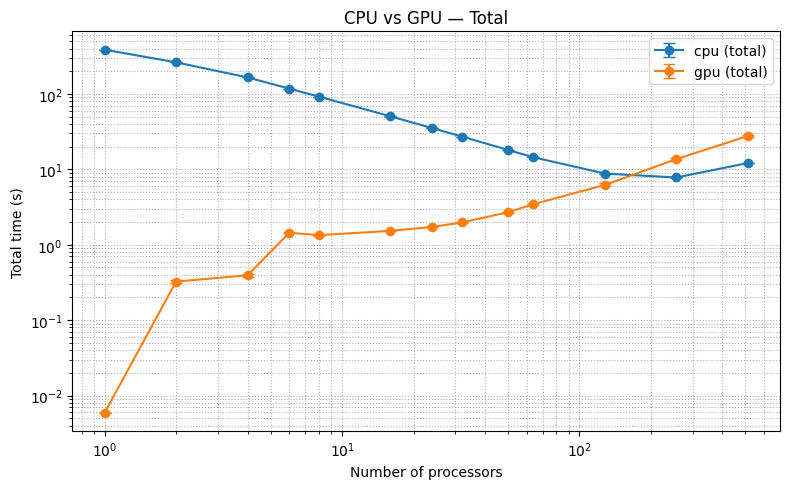

In [41]:
plt.figure(figsize=(8,5))
for dev in summary["device"].unique():
    sub = summary[summary["device"] == dev].sort_values("num_procs")
    plt.errorbar(sub["num_procs"], sub["total_mean"], yerr=sub["total_std"], marker="o", capsize=4, label=f"{dev} (total)")
plt.xscale("log")
plt.xlabel("Number of processors")
plt.ylabel("Total time (s)")
plt.yscale("log")
plt.title("CPU vs GPU — Total")
plt.legend(); plt.grid(True, which="both", ls=":")
savefig(results_dir, "total_time")

## Speedup vs processors — Distribution

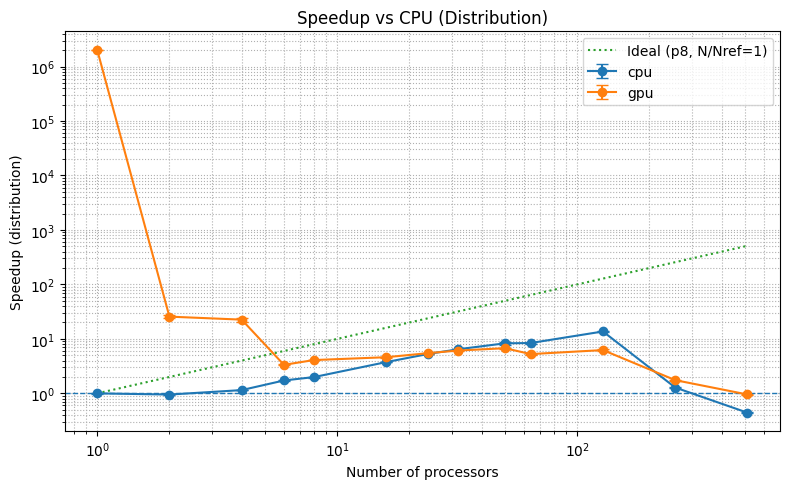

In [44]:
plt.figure(figsize=(8,5))
for dev in with_base["device"].unique():
    sub = with_base[with_base["device"] == dev].sort_values("num_procs")
    plt.errorbar(sub["num_procs"], sub["speedup_dist"], yerr=sub["speedup_dist_s"], marker="o", capsize=4, label=dev)
plt.axhline(1.0, ls="--", lw=1)
for pw in sorted(with_base["power"].unique()):
    g = with_base[with_base["power"] == pw]
    if g.empty: continue
    nref = g["cpu_base_nprocs"].iloc[0]
    xs = sorted(g["num_procs"].unique())
    ys = [x/nref for x in xs]
    plt.plot(xs, ys, ls=":", lw=1.5, label=f"Ideal (p{pw}, N/Nref={nref})")
plt.xscale("log")
plt.xlabel("Number of processors")
plt.ylabel("Speedup (distribution)")
plt.yscale("log")
plt.title("Speedup vs CPU (Distribution)")
plt.legend(); plt.grid(True, which="both", ls=":")
savefig(results_dir, "speedup_distribution")

## Speedup vs processors — Splitters

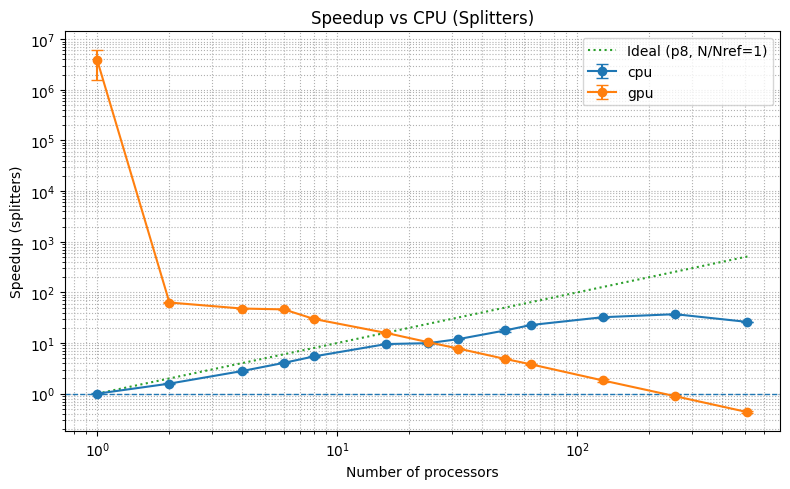

In [45]:
plt.figure(figsize=(8,5))
for dev in with_base["device"].unique():
    sub = with_base[with_base["device"] == dev].sort_values("num_procs")
    plt.errorbar(sub["num_procs"], sub["speedup_split"], yerr=sub["speedup_split_s"], marker="o", capsize=4, label=dev)
plt.axhline(1.0, ls="--", lw=1)
for pw in sorted(with_base["power"].unique()):
    g = with_base[with_base["power"] == pw]
    if g.empty: continue
    nref = g["cpu_base_nprocs"].iloc[0]
    xs = sorted(g["num_procs"].unique())
    ys = [x/nref for x in xs]
    plt.plot(xs, ys, ls=":", lw=1.5, label=f"Ideal (p{pw}, N/Nref={nref})")
plt.xscale("log")
plt.xlabel("Number of processors")
plt.yscale("log")
plt.ylabel("Speedup (splitters)")
plt.title("Speedup vs CPU (Splitters)")
plt.legend(); plt.grid(True, which="both", ls=":")
savefig(results_dir, "speedup_splitters")

## Speedup vs processors — Generation

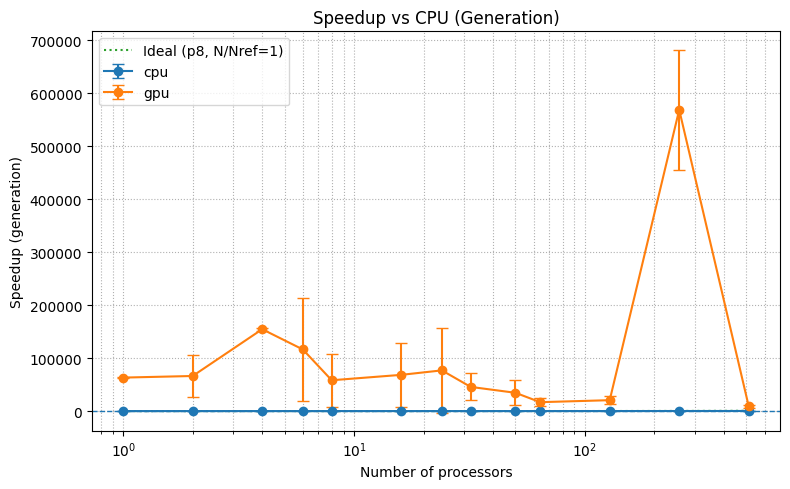

In [35]:
plt.figure(figsize=(8,5))
for dev in with_base["device"].unique():
    sub = with_base[with_base["device"] == dev].sort_values("num_procs")
    plt.errorbar(sub["num_procs"], sub["speedup_gen"], yerr=sub["speedup_gen_s"], marker="o", capsize=4, label=dev)
plt.axhline(1.0, ls="--", lw=1)
for pw in sorted(with_base["power"].unique()):
    g = with_base[with_base["power"] == pw]
    if g.empty: continue
    nref = g["cpu_base_nprocs"].iloc[0]
    xs = sorted(g["num_procs"].unique())
    ys = [x/nref for x in xs]
    plt.plot(xs, ys, ls=":", lw=1.5, label=f"Ideal (p{pw}, N/Nref={nref})")
plt.xscale("log")
plt.xlabel("Number of processors")
plt.ylabel("Speedup (generation)")
plt.title("Speedup vs CPU (Generation)")
plt.legend(); plt.grid(True, which="both", ls=":")
savefig(results_dir, "speedup_generation")

## Speedup vs processors — Total

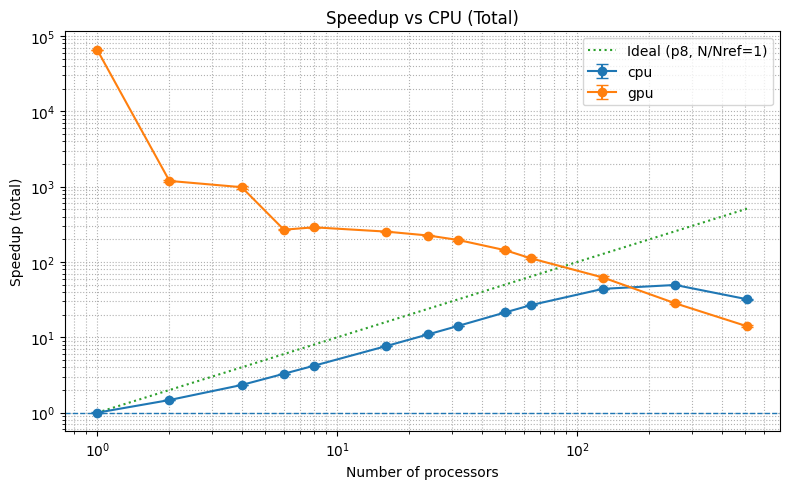

In [46]:
plt.figure(figsize=(8,5))
for dev in with_base["device"].unique():
    sub = with_base[with_base["device"] == dev].sort_values("num_procs")
    plt.errorbar(sub["num_procs"], sub["speedup_total"], yerr=sub["speedup_total_s"], marker="o", capsize=4, label=dev)
plt.axhline(1.0, ls="--", lw=1)
for pw in sorted(with_base["power"].unique()):
    g = with_base[with_base["power"] == pw]
    if g.empty: continue
    nref = g["cpu_base_nprocs"].iloc[0]
    xs = sorted(g["num_procs"].unique())
    ys = [x/nref for x in xs]
    plt.plot(xs, ys, ls=":", lw=1.5, label=f"Ideal (p{pw}, N/Nref={nref})")
plt.xscale("log")
plt.xlabel("Number of processors")
plt.ylabel("Speedup (total)")
plt.yscale("log")
plt.title("Speedup vs CPU (Total)")
plt.legend(); plt.grid(True, which="both", ls=":")
savefig(results_dir, "speedup_total")

## Speedup vs processors — Total

In [37]:
plt.figure(figsize=(8,5))
for dev in with_base["device"].unique():
    sub = with_base[with_base["device"] == dev].sort_values("num_procs")
    plt.errorbar(sub["num_procs"], sub["speedup_total"], yerr=sub["speedup_total_s"], marker="o", capsize=4, label=dev)
plt.axhline(1.0, ls="--", lw=1)
for pw in sorted(with_base["power"].unique()):
    g = with_base[with_base["power"] == pw]
    if g.empty: continue
    nref = g["cpu_base_nprocs"].iloc[0]
    xs = sorted(g["num_procs"].unique()])
    ys = [x/nref for x in xs]
    plt.plot(xs, ys, ls=":", lw=1.5, label=f"Ideal (p{pw}, N/Nref={nref})")
plt.xscale("log")
plt.xlabel("Number of processors")
plt.ylabel("Speedup (total)")
plt.title("Speedup vs CPU (Total)")
plt.legend(); plt.grid(True, which="both", ls=":")
savefig(results_dir, "speedup_total")

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (3219697342.py, line 10)

## Parallel efficiency — Total (baseline n=2)

In [ ]:
ref2_total = (
    summary[summary["num_procs"] == BASE_EFF_NPROCS]
      .rename(columns={"num_procs":"n_ref","total_mean":"t_ref","total_std":"s_ref"})
      [["device","power","n_ref","t_ref","s_ref"]]
)

eff_total = summary.merge(ref2_total, on=["device","power"], how="left")

eff_total["eff_strong"] = np.nan
good = (
    eff_total["n_ref"].notna() &
    (eff_total["t_ref"] > 0) & np.isfinite(eff_total["t_ref"]) &
    (eff_total["total_mean"] > 0) & np.isfinite(eff_total["total_mean"])
)
eff_total.loc[good, "eff_strong"] = (
    eff_total.loc[good, "t_ref"] * eff_total.loc[good, "n_ref"]
) / (eff_total.loc[good, "total_mean"] * eff_total.loc[good, "num_procs"])

eff_total["eff_strong_s"] = np.nan
eff_total.loc[good, "eff_strong_s"] = eff_total.loc[good, "eff_strong"] * np.sqrt(
    (eff_total.loc[good, "s_ref"] / eff_total.loc[good, "t_ref"])**2 +
    (eff_total.loc[good, "total_std"] / eff_total.loc[good, "total_mean"])**2
)

plt.figure(figsize=(8,5))
for (dev,pw), g in eff_total[good].sort_values("num_procs").groupby(["device","power"]):
    plt.errorbar(g["num_procs"], g["eff_strong"], yerr=g["eff_strong_s"],
                 marker="o", capsize=4, label=f"{dev} (p{pw})")
plt.axhline(1.0, ls="--")
plt.xscale("log")
plt.xlabel("Number of processors")
plt.ylabel("Parallel efficiency (strong, baseline n=2)")
plt.title("Parallel efficiency (Total) — baseline n=2")
plt.legend(); plt.grid(True, which="both", ls=":")
savefig(results_dir, "efficiency_total_n2")

## Parallel efficiency — Distribution / Generation / Splitters (baseline n=2)

In [ ]:
def plot_eff(mean_col, std_col, title, fname):
    ref_x = (
        summary[summary["num_procs"] == BASE_EFF_NPROCS]
          .rename(columns={"num_procs":"n_ref", mean_col:"t_ref", std_col:"s_ref"})
          [["device","power","n_ref","t_ref","s_ref"]]
    )
    e2 = summary.merge(ref_x, on=["device","power"], how="left")

    e2["eff"] = np.nan
    good = (
        e2["n_ref"].notna() &
        (e2["t_ref"] > 0) & np.isfinite(e2["t_ref"]) &
        (e2[mean_col] > 0) & np.isfinite(e2[mean_col])
    )
    e2.loc[good, "eff"] = (
        e2.loc[good, "t_ref"] * e2.loc[good, "n_ref"]
    ) / (e2.loc[good, mean_col] * e2.loc[good, "num_procs"])

    e2["eff_s"] = np.nan
    e2.loc[good, "eff_s"] = e2.loc[good, "eff"] * np.sqrt(
        (e2.loc[good, "s_ref"] / e2.loc[good, "t_ref"])**2 +
        (e2.loc[good, std_col] / e2.loc[good, mean_col])**2
    )

    plt.figure(figsize=(8,5))
    for (dev,pw), g in e2[good].sort_values("num_procs").groupby(["device","power"]):
        plt.errorbar(g["num_procs"], g["eff"], yerr=g["eff_s"],
                     marker="o", capsize=4, label=f"{dev} (p{pw})")
    plt.axhline(1.0, ls="--")
    plt.xscale("log")
    plt.xlabel("Number of processors")
    plt.ylabel("Parallel efficiency (strong, baseline n=2)")
    plt.title(f"{title} — baseline n=2")
    plt.legend(); plt.grid(True, which="both", ls=":")
    savefig(results_dir, fname)

plot_eff("dist_mean","dist_std","Parallel efficiency — Distribution","efficiency_distribution_n2")
plot_eff("gen_mean","gen_std","Parallel efficiency — Generation","efficiency_generation_n2")
plot_eff("split_mean","split_std","Parallel efficiency — Splitters","efficiency_splitters_n2")

## Time vs nodes — Distribution

In [ ]:
plt.figure(figsize=(8,5))
agg = (summary.groupby(["device","power","nodes"], as_index=False)
             .agg(y_mean=("dist_mean","mean"), y_std=("dist_std","mean")))
for (dev,pw), g in agg.sort_values(["nodes"]).groupby(["device","power"]):
    plt.errorbar(g["nodes"], g["y_mean"], yerr=g["y_std"], marker="o", capsize=4, label=f"{dev} (p{pw})")
plt.xlabel("Number of nodes used")
plt.ylabel("Distribution time (s)")
plt.title("Distribution time vs nodes used")
plt.grid(True, ls=":"); plt.legend()
savefig(results_dir, "time_vs_nodes_distribution")

## Time vs nodes — Distribution

In [ ]:
plt.figure(figsize=(8,5))
agg = (summary.groupby(["device","power","nodes"], as_index=False)
             .agg(y_mean=("dist_mean","mean"), y_std=("dist_std","mean")))
for (dev,pw), g in agg.sort_values(["nodes"]).groupby(["device","power"]):
    plt.errorbar(g["nodes"], g["y_mean"], yerr=g["y_std"], marker="o", capsize=4, label=f"{dev} (p{pw})")
plt.xlabel("Number of nodes used")
plt.ylabel("Distribution time (s)")
plt.title("Distribution time vs nodes used")
plt.grid(True, ls=":"); plt.legend()
savefig(results_dir, "time_vs_nodes_distribution")

## Time vs nodes — Splitters

In [ ]:
plt.figure(figsize=(8,5))
agg = (summary.groupby(["device","power","nodes"], as_index=False)
             .agg(y_mean=("split_mean","mean"), y_std=("split_std","mean")))
for (dev,pw), g in agg.sort_values(["nodes"]).groupby(["device","power"]):
    plt.errorbar(g["nodes"], g["y_mean"], yerr=g["y_std"], marker="o", capsize=4, label=f"{dev} (p{pw})")
plt.xlabel("Number of nodes used")
plt.ylabel("Splitters time (s)")
plt.title("Splitters time vs nodes used")
plt.grid(True, ls=":"); plt.legend()
savefig(results_dir, "time_vs_nodes_splitters")

## Time vs nodes — Generation

In [ ]:
plt.figure(figsize=(8,5))
agg = (summary.groupby(["device","power","nodes"], as_index=False)
             .agg(y_mean=("gen_mean","mean"), y_std=("gen_std","mean")))
for (dev,pw), g in agg.sort_values(["nodes"]).groupby(["device","power"]):
    plt.errorbar(g["nodes"], g["y_mean"], yerr=g["y_std"], marker="o", capsize=4, label=f"{dev} (p{pw})")
plt.xlabel("Number of nodes used")
plt.ylabel("Generation time (s)")
plt.title("Generation time vs nodes used")
plt.grid(True, ls=":"); plt.legend()
savefig(results_dir, "time_vs_nodes_generation")

## Time vs nodes — Total

In [ ]:
plt.figure(figsize=(8,5))
agg = (summary.groupby(["device","power","nodes"], as_index=False)
             .agg(y_mean=("total_mean","mean"), y_std=("total_std","mean")))
for (dev,pw), g in agg.sort_values(["nodes"]).groupby(["device","power"]):
    plt.errorbar(g["nodes"], g["y_mean"], yerr=g["y_std"], marker="o", capsize=4, label=f"{dev} (p{pw})")
plt.xlabel("Number of nodes used")
plt.ylabel("Total time (s)")
plt.title("Total time vs nodes used")
plt.grid(True, ls=":"); plt.legend()
savefig(results_dir, "time_vs_nodes_total")